## Corriente de electrones en sistemas abiertos de dos puntos cuánticos 

In [1]:
from joblib import delayed, Parallel

from tqdm.auto import tqdm
import numpy as np

import qutip as qt
import matplotlib.pyplot as plt
import scipy

%matplotlib widget

In [54]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

def hex_to_rgba(hex_color):
    """
    Convierte un color en formato hexadecimal a formato RGBA.
    
    Args:
    - hex_color: Color en formato hexadecimal.
    
    Returns:
    - Color en formato RGBA.
    """
    rgb = mcolors.hex2color(hex_color)
    return (*rgb, 1)

def create_custom_cmap(colors, positions):
    """
    Crea un colormap personalizado a partir de una lista de colores y sus posiciones.
    
    Args:
    - colors: Lista de colores en formato hexadecimal.
    - positions: Lista de posiciones normalizadas (entre 0 y 1).
    
    Returns:
    - Colormap personalizado.
    """
    if len(colors) != len(positions):
        raise ValueError("La longitud de 'colors' debe ser igual a la longitud de 'positions'.")
    
    rgba_colors = [hex_to_rgba(color) for color in colors]
    
    cmap_dict = {'red': [], 'green': [], 'blue': []}
    
    for pos, color in zip(positions, rgba_colors):
        for i, channel in enumerate(['red', 'green', 'blue']):
            cmap_dict[channel].append((pos, color[i], color[i]))
    
    return LinearSegmentedColormap('custom_colormap', cmap_dict)

# Definir lista de colores en formato hexadecimal y posiciones
hex_colors = ['w','#C1CFF6','#5F9EA0','#4D8283','#537E83','#DF9595','#E19B9B', '#F17F8A','#F13D70']
positions = [0.0, 0.05, 0.12,0.2,0.28,0.53,0.57,0.72,1]  # Normalizado entre 0 y 1

# Crear el colormap personalizado
custom_cmap = create_custom_cmap(hex_colors, positions)

El Hamiltoniano del sistema en la base $\mathscr{B}=\{\ket{\varnothing}, \ket{L}, \ket{R}\}$:

$H= \begin{pmatrix}
        0 & 0 & 0 \\
        0 & \delta/2 & \tau/2 \\
        0 & \tau/2 & -\delta/2
    \end{pmatrix}$

In [2]:
# base
E = qt.basis(3, 0)
L = qt.basis(3, 1)
R = qt.basis(3, 2)

In [56]:
# parámetros y operadores
gammaL = 0.05
gammaR = 0.05
psi0 = E

cL = qt.Qobj(np.array([(0,1,0),(0,0,0),(0,0,0)]))
cR = qt.Qobj(np.array([(0,0,1),(0,0,0),(0,0,0)]))

LL = np.sqrt(gammaL)*cL
LR = np.sqrt(gammaR)*cR

c_ops = [qt.dag(LL),LR]

La corriente que se medirá vendrá dada por $I=e\rho_{RR}\Gamma_R$. Hacemos $\Gamma_R=\Gamma_L$.

In [57]:
def pixel(delta, tau):
    H = qt.Qobj(np.array([(0,0,0),(0,delta/2,tau/2), (0,tau/2,-delta/2)]))
    state = qt.steadystate(H, c_ops)
    pR = (R.overlap(state))
    return pR

In [58]:
# pintamos la corriente normalizada (I=rho_RR) para distintos valores del detuning y de tau
deltas = np.linspace(-200, 200, 201) * gammaR
taus = np.linspace(0, 20, 200) * gammaR

pRs = []
deltas_mat = []
taus_mat = []

for i in range(len(deltas)):
     for j in range(len(taus)):
        taus_mat.append(taus[j])
        deltas_mat.append(deltas[i])

In [59]:
pbar = tqdm(range(len(deltas_mat)), desc='Calculando...')
resultados = Parallel(n_jobs=-1)(delayed(pixel)(deltas_mat[i], taus_mat[i]) for i in pbar)
np.save('current_dqd.npy', resultados)

Calculando...:   0%|          | 0/40200 [00:00<?, ?it/s]

In [60]:
resultados = np.load('current_dqd.npy')
resultados_mat = np.array(resultados).reshape((len(deltas), len(taus)))

In [61]:
taus_2 = np.array([4, 10, 16]) * gammaR
pRs_s = []
for tau in taus_2:
    pRs=[]
    for delta in deltas:
        H = qt.Qobj(np.array([(0,0,0),(0,delta/2,tau/2), (0,tau/2,-delta/2)]))
        state = qt.steadystate(H, c_ops)
        pRs.append((R.overlap(state)))
    pRs_s.append(pRs)

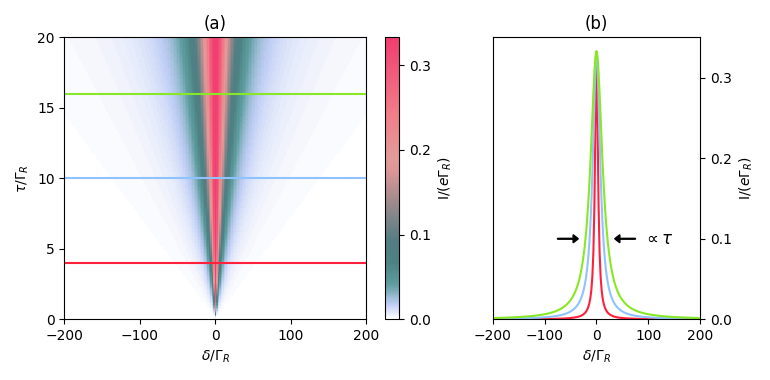

In [161]:
fig, axs = plt.subplots(1, 2, figsize=(7.7, 3.8), gridspec_kw={'width_ratios': [1, 0.55]})
colors = ['#ff213b', '#8fc3ff', '#88e827']

# Figura (a)
im = axs[0].imshow(resultados_mat.T, cmap = custom_cmap, origin='lower', aspect='auto',
                interpolation='none', extent=[min(deltas)/gammaR, max(deltas)/gammaR, min(taus)/gammaR, max(taus)/gammaR])
axs[0].set_xlabel(r'$\delta/\Gamma_R$')
axs[0].set_ylabel(r'$\tau/\Gamma_R$')
axs[0].set_title(r'(a)')
axs[0].set_yticks([0,5,10,15,20])
cbar = plt.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel(r'I$/(e\Gamma_R)$')
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

for i in range(len(taus_2)):
    axs[0].hlines(taus_2[i] / gammaR, color=colors[i],  xmin=min(deltas) / gammaR, xmax=max(deltas) / gammaR)

# Figura (b)
for i in range(3):
    axs[1].plot(deltas / gammaR, pRs_s[i], color=colors[i])

axs[1].set_xlabel(r'$\delta/\Gamma_R$')
axs[1].set_ylabel(r'I$/(e\Gamma_R)$', labelpad=None)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")

axs[1].set_yticks([0, 0.1, 0.2, 0.3])

axs[1].set_xlim(min(deltas) / gammaR, max(deltas) / gammaR)
axs[1].set_ylim(0, 0.35)

x_0 = 75
dx = 30
axs[1].arrow(-x_0, 0.1, dx, 0, color='k', head_width=0.01, head_length=10)
axs[1].arrow(x_0, 0.1, -dx, 0, color='k', head_width=0.01, head_length=10)
axs[1].text(90, 0.1, r'$\propto\tau$',fontsize = 12, va='center')
axs[1].set_title('(b)')

plt.subplots_adjust(wspace=0.2)
plt.tight_layout()

plt.savefig('./figs/current_dqd.pdf')

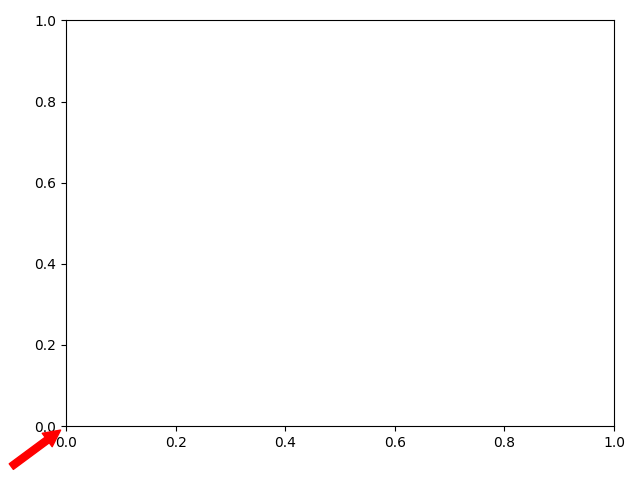

In [144]:
fig, ax = plt.subplots()

start = 0.05
ax.annotate("", xy=(-0.01, -0.01), xytext=(-start * 2, -start * 2),
            arrowprops=dict(color='r', width=5), annotation_clip=False)

plt.tight_layout()

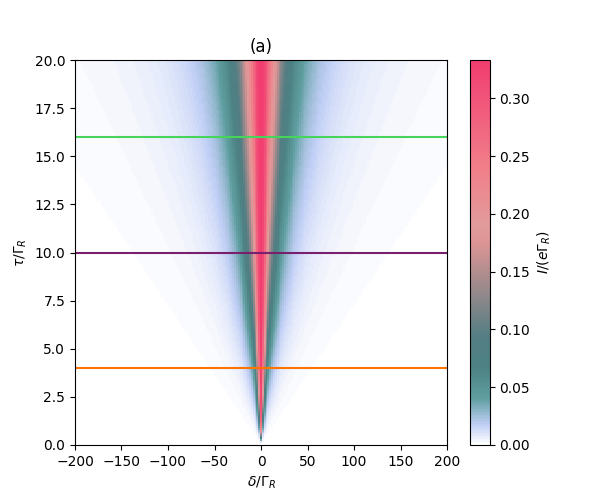

In [10]:
fig, ax = plt.subplots(figsize=(6 , 5))
im = ax.imshow(resultados_mat.T, cmap = custom_cmap, origin='lower', aspect='auto',
                interpolation='none', extent=[min(deltas)/gammaR, max(deltas)/gammaR, min(taus)/gammaR, max(taus)/gammaR])
plt.xlabel(r'$\delta/\Gamma_R$')
plt.ylabel(r'$\tau/\Gamma_R$')
plt.title(r'(a)')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'$I/(e\Gamma_R)$')

plt.axhline(4, color='#ff7300', xmax=1)
plt.axhline(10, color='#78206e', xmax=1)
plt.axhline(16, color='#47d45a', xmax=1)

plt.savefig('./figs/current_dqd.pdf')

Text(0.5, 1.0, '(b)')

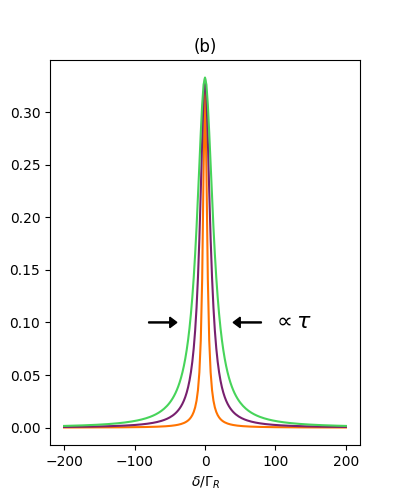

In [49]:
fig, ax = plt.subplots(figsize=(4, 5))

colors = ['#ff7300', '#78206e', '#47d45a']
for i in range(3):
    ax.plot(deltas / gammaR, pRs_s[i], color=colors[i])

plt.xlabel(r'$\delta/\Gamma_R$')
plt.ylabel(r'$I/(e\Gamma_R)$')

x_0 = 80
dx = 30
ax.arrow(-x_0, 0.1, dx, 0, color='k', head_width=0.01, head_length=10)
ax.arrow(x_0, 0.1, -dx, 0, color='k', head_width=0.01, head_length=10)
#ax.annotate("", xy=(0.5, 0.5), xytext=(0, 0),
#            arrowprops=dict(arrowstyle="->"))
#plt.text(1.05, 0.1, r'$⟵$',fontsize = 22)
#plt.text(-3.05, 0.1, r'$⟶$',fontsize = 22)
plt.text(95, 0.1, r'$\propto\tau$',fontsize = 16, va='center')
plt.title('(b)')


# plt.savefig('./figs/current_dqd_plot.pdf')